In [2]:
# import de la base de données excel
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

df = pd.read_excel('D:/ENSAI_RENNES/3A/LESSONS\Techniques et methodes de scoring/Projet/donnees/sci.xlsx')

In [ ]:
# Suppression des variables illégales
#var_illegales = ['CODPAY_NAISSANCE', 'CODPAY_NATIONALITE','CODSEXPRS','CODCMNIEE'] # CODPAY_RESIDENCE
#df.drop(columns=var_illegales, inplace=True)

### Vérifications préliminaires

In [3]:
# Vérification des doublons par ligne dans la base de données
print(df.duplicated().sum())

0


In [4]:
# Vérification des doublons par colonnes
all(df['CRTAD_AG_SOLDE_T']==df["CRTAE_AG_SLDEPA"])

False

In [5]:
print(f"{all(df['DATCREENT'==df['DATCREPRSENT']])=}")
df.drop(columns=['DATCREPRSENT'],inplace=True)

all(df['DATCREENT'==df['DATCREPRSENT']])=True


In [6]:
var_redondantes = ['secteur_activite', 'secteur_activite_bis' ]
df.drop(columns=var_redondantes,inplace=True)

# I. Identification de la variable cible et analyse des variables explicatives

## I.1. La variable cible 

In [7]:
cible = "DDefaut_NDB"
print("Initial type of target column")
print(df[[cible]].dtypes)

Initial type of target column
DDefaut_NDB    int64
dtype: object


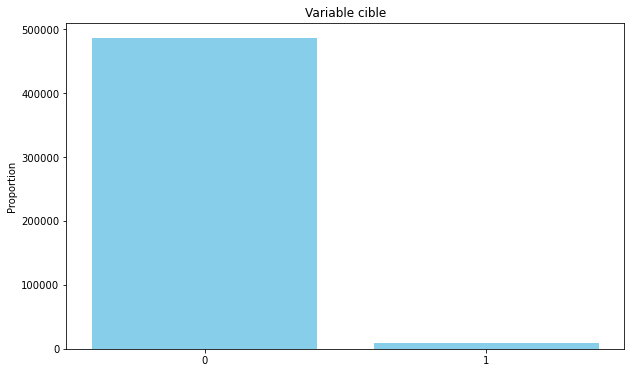

In [8]:

import matplotlib.pyplot as plt

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df[cible].value_counts().index.astype(str), df[cible].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [9]:
#Transformer le format de date :
print("Nombre de dates : ",df[['datdelhis']].nunique())
print("Format de date initial: ", df[['datdelhis']].dtypes)


df['datdelhis'] = pd.to_datetime(df['datdelhis'], format = '%Y%m')
print("Format de date final: ", df[['datdelhis']].dtypes)


Nombre de dates :  datdelhis    6
dtype: int64
Format de date initial:  datdelhis    int64
dtype: object
Format de date final:  datdelhis    datetime64[ns]
dtype: object


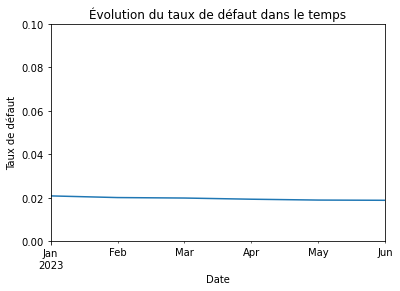

In [10]:
# Evolution de la variable cible dans le temps
import matplotlib.pyplot as plt

taux_cible = df.groupby(df['datdelhis'].dt.to_period('M'))['DDefaut_NDB'].mean() # ou sum()

# Tracer le taux de la variable cible au fil du temps
taux_cible.plot(title='Évolution du taux de défaut dans le temps')
plt.xlabel('Date')
plt.ylabel('Taux de défaut')
plt.ylim(0,0.1)
plt.show()

## I.2. Construction de la base d'échantillon

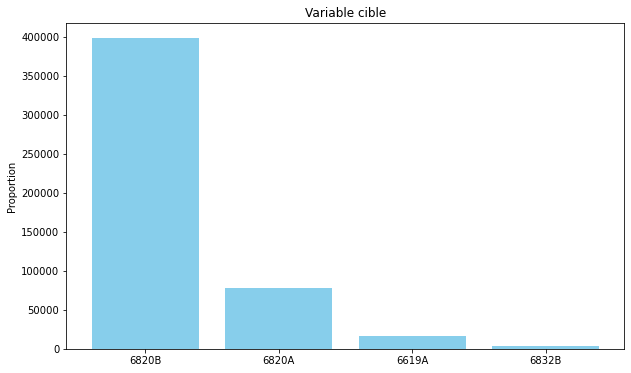

In [11]:
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df['CODNAF2'].value_counts().index.astype(str), df['CODNAF2'].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

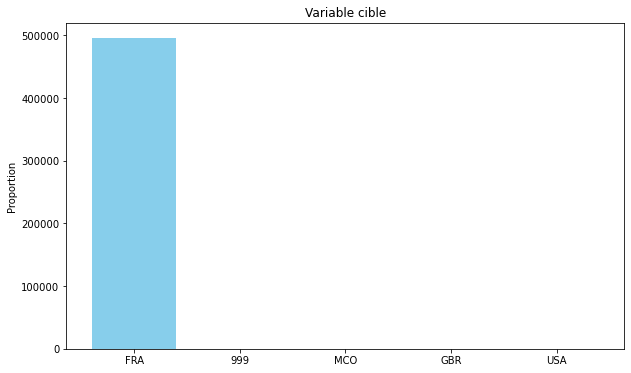

In [12]:
### Attention au biais lié au pays de résidence
### Impossibilité de stratifier par pays de résidence
### Soit on travaille qu'avec la France, soit on a conscience du biais régionale.

plt.figure(figsize=(10, 6))
plt.bar(df['CODPAY_RESIDENCE'].value_counts().index.astype(str), df['CODPAY_RESIDENCE'].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [13]:
df['CODPAY_RESIDENCE'].value_counts(normalize=True)

FRA    0.999655
999    0.000161
MCO    0.000159
GBR    0.000012
USA    0.000012
Name: CODPAY_RESIDENCE, dtype: float64

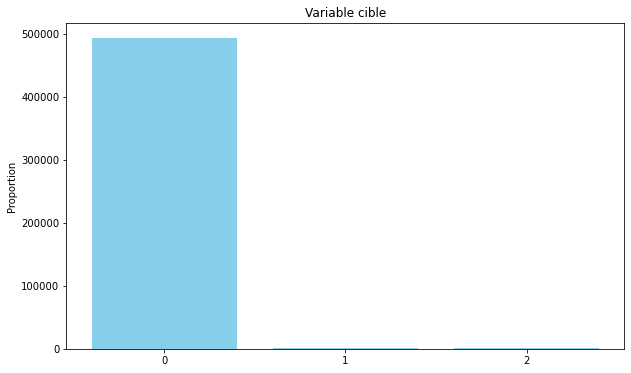

In [14]:
plt.figure(figsize=(10, 6))
plt.bar(df['CODSEXPRS'].value_counts().index.astype(str), df['CODSEXPRS'].value_counts(), color='skyblue')

plt.ylabel('Proportion')
plt.title('Variable cible')

plt.show()

In [15]:
# Biais lié au sexe et au type de client (personne morale, physique)
df['CODSEXPRS'].value_counts(normalize=True)
df['IND_PER_PM'].value_counts(normalize=True)


PM    0.994987
PP    0.005013
Name: IND_PER_PM, dtype: float64

In [ ]:
## crée une variable qui prend en entrée une variable qualitative 
# si la variable ne prend pratiquement qu'une modalité (à partir d'un seuil qu'on se fixe)
# on ne l'utilise pas dans le modèle

In [16]:
## Creation des echantillons train et test 
from sklearn.model_selection import train_test_split

# Retrait des mauvaises variables de prédictions (variables ne prenant pratiquement qu'une seule modalité)
X = df.drop(columns = [cible,'id_client','CODSEXPRS','IND_PER_PM','CODPAY_RESIDENCE'])
y = df[cible]
X['stratify_col'] = df[cible].astype(str) + '_' + df['datdelhis'].astype(str) + '_' +  df['CODNAF2'].astype(str) 

# Split train-test stratifié en utilisant la colonne combinée
X_train, X_test, y_train, y_test = train_test_split(
    X,  y,
    stratify=X['stratify_col'],  # La nouvelle colonne pour la stratification
    test_size=0.2,                # La proportion de l'ensemble de test
    random_state=42               # La graine pour la reproductibilité
)


In [17]:
# Suppression de la colonne de stratification car non utile pour la suite
X_train = X_train.drop(['stratify_col'], axis=1)
X_test = X_test.drop(['stratify_col'], axis=1)

In [18]:
#df.info()
# 64 colonnes au total, 56 colonnes de type float ou int, 
# 6 colonnes de type object (supposées qualitatives), 
# 2 colonnes de types date

#### ANALYSE DE LA REPRESENTATITVITÉ DES VARIABLES

In [19]:
# Vérification de la répartition de la variable cible dans le train et le test

print("Répartition de la cible dans le train :")
print(y_train.value_counts(normalize=True))

print("\nRépartition de la cible dans le test :")
print(y_test.value_counts(normalize=True))


Répartition de la cible dans le train :
0    0.980374
1    0.019626
Name: DDefaut_NDB, dtype: float64

Répartition de la cible dans le test :
0    0.980374
1    0.019626
Name: DDefaut_NDB, dtype: float64


In [20]:
#### On verifie que la repartition des elements ayant servis à la stratification est la même dans nos echantillons train et test
# Vérification de la répartition des combinaisons dans la colonne de stratification

print("Répartition relative des dates d'observation dans le train :")
print(X_train['datdelhis'].value_counts(normalize=True))

print("\nRépartition relative des dates d'observation dans le test :")
print(X_test['datdelhis'].value_counts(normalize=True))



Répartition relative des dates d'observation dans le train :
2023-06-01    0.168388
2023-05-01    0.167720
2023-04-01    0.167236
2023-03-01    0.166620
2023-02-01    0.166040
2023-01-01    0.163996
Name: datdelhis, dtype: float64

Répartition relative des dates d'observation dans le test :
2023-06-01    0.168380
2023-05-01    0.167704
2023-04-01    0.167220
2023-03-01    0.166635
2023-02-01    0.166049
2023-01-01    0.164011
Name: datdelhis, dtype: float64


In [21]:

print("Répartition relative du secteur d'activité dans le train :")
print(X_train['CODNAF2'].value_counts(normalize=True))

print("\nRépartition relative du secteur d'activité dans le test :")
print(X_test['CODNAF2'].value_counts(normalize=True))

Répartition relative du secteur d'activité dans le train :
6820B    0.803028
6820A    0.157569
6619A    0.032411
6832B    0.006993
Name: CODNAF2, dtype: float64

Répartition relative du secteur d'activité dans le test :
6820B    0.803033
6820A    0.157584
6619A    0.032401
6832B    0.006983
Name: CODNAF2, dtype: float64


In [22]:
#### On peut également s'assurer que la distribution des variables continues est la même dans notre train et dans notre test 
#### Ce qui pourrait indiquer que notre stratification a capté l'ensemble des variables importantes.

### Nous avons donc choisi quelques variables que nous estimions pertinentes pour ce faire

# Liste des variables continues à analyser
variables_continues = ['ANCIENNETE', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_SOLDE_IND_0009', 
                       'CRTAR_IND_0036', 'CRTAD_AG_NBJDE_BA', 'CRTAD_IND_0062']

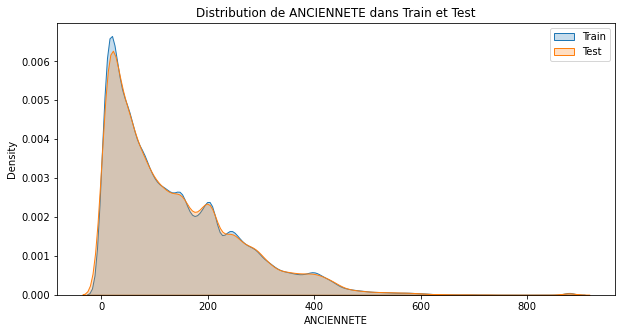

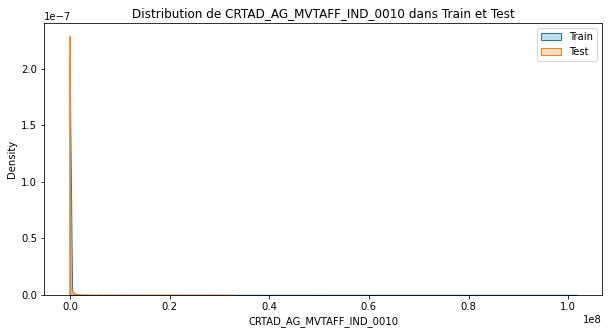

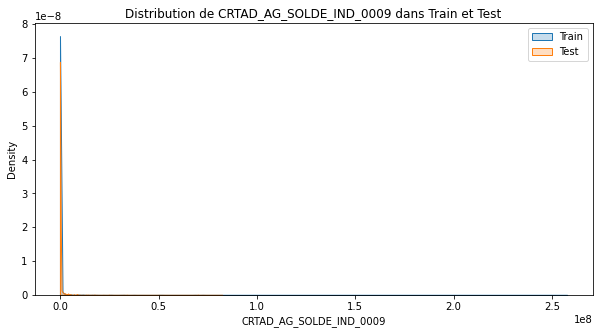

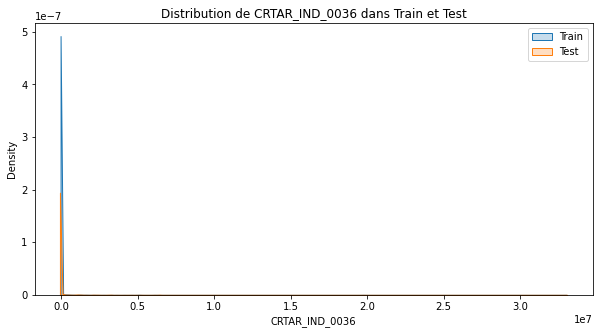

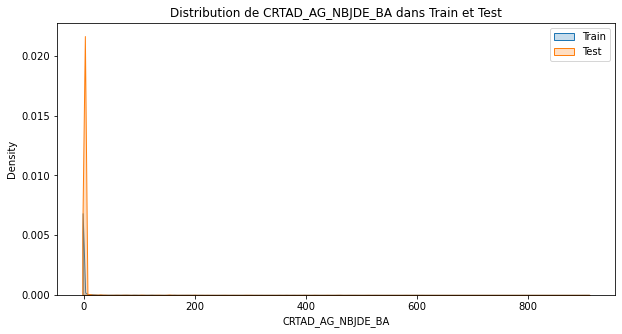

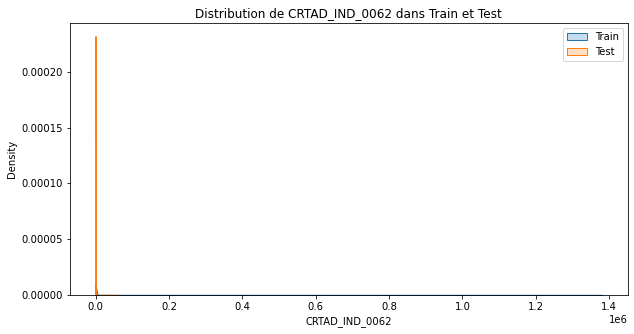

In [23]:
#### Analyses visuelles des distributions (KDE)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Comparer les distributions des variables continues dans train et test
for col in variables_continues:
    plt.figure(figsize=(10, 5))
    sns.kdeplot(X_train[col], label='Train', shade=True)
    sns.kdeplot(X_test[col], label='Test', shade=True)
    plt.title(f"Distribution de {col} dans Train et Test")
    plt.legend()
    plt.show()

In [24]:

# Comparer la distribution de chaque variable continue dans le train et le test

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

# Liste des variables continues à analyser
variables_continues = ['ANCIENNETE', 'CRTAD_AG_MVTAFF_IND_0010', 'CRTAD_AG_SOLDE_IND_0009', 
                       'CRTAR_IND_0036', 'CRTAD_AG_NBJDE_BA', 'CRTAD_IND_0062']

# Comparer la distribution de chaque variable continue dans le train et le test
for var in variables_continues:
    # Calcul des statistiques descriptives pour train et test
    print(f"Statistiques descriptives de {var} dans le train :")
    print(X_train[var].describe())
    print(f"\nStatistiques descriptives de {var} dans le test :")
    print(X_test[var].describe())
    
    # Test de Kolmogorov-Smirnov pour vérifier si les distributions sont similaires
    ks_stat, ks_p_value = stats.ks_2samp(X_train[var], X_test[var])
    print(f"\nTest de Kolmogorov-Smirnov pour {var}: p-value = {ks_p_value}")
    if ks_p_value > 0.05:
        print("Les distributions sont similaires (p-value > 0.05).")
    else:
        print("Les distributions ne sont pas similaires (p-value < 0.05).")
    print("\n" + "-"*50)




Statistiques descriptives de ANCIENNETE dans le train :
count    396411.000000
mean        134.365999
std         119.423212
min           0.000000
25%          39.000000
50%         101.000000
75%         202.000000
max         881.000000
Name: ANCIENNETE, dtype: float64

Statistiques descriptives de ANCIENNETE dans le test :
count    99103.000000
mean       134.638881
std        119.710943
min          0.000000
25%         38.000000
50%        101.000000
75%        203.000000
max        881.000000
Name: ANCIENNETE, dtype: float64

Test de Kolmogorov-Smirnov pour ANCIENNETE: p-value = 0.5018536293377618
Les distributions sont similaires (p-value > 0.05).

--------------------------------------------------
Statistiques descriptives de CRTAD_AG_MVTAFF_IND_0010 dans le train :
count    3.964110e+05
mean     4.796051e+03
std      2.775689e+05
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.016746e+08
Name: CRTAD_AG_MVTAFF_IND_0010, dtype:

## I.3. Création de nouveaux indicateurs et pré-sélection des variables candidates à l’explication de la variable cible

#### Pré-selection des variables


In [47]:
###On sépare au préalable les variables catégorielles de celles nummériques

object_columns = X_train.select_dtypes(include=['object']).columns.tolist()
float_columns = X_train.select_dtypes(include=['float64','int64']).columns.tolist()

print(len(object_columns)) #Assuming object variables are categorical and float/int variables are numerical
print(len(float_columns))

4
54


In [28]:
object_columns

['CODNAF2', 'TOP_PRO_ACTIF', 'CODPAY_NAISSANCE', 'CODPAY_NATIONALITE']

##### On s'assure que nos données soient :

##### Fiables

In [22]:
### Fiables
# Calculer le taux de valeurs manquantes (en pourcentage) pour chaque colonne
missing_percentages = X_train.isna().mean() * 100

# Filtrer uniquement les colonnes avec des valeurs manquantes
missing_columns = missing_percentages[missing_percentages > 0]

# Afficher le nombre de colonnes avec des valeurs manquantes
print(f"Nombre de colonnes avec des valeurs manquantes : {len(missing_columns)}")

# Afficher le taux de valeurs manquantes uniquement pour ces colonnes
print("\nTaux de valeurs manquantes par colonne (%):")
print(missing_columns)


Nombre de colonnes avec des valeurs manquantes : 4

Taux de valeurs manquantes par colonne (%):
DATCREENT           100.000000
INDPARDCD            99.503293
CODCMNIEE            99.503293
CODPAY_NAISSANCE     99.503293
dtype: float64


In [43]:
modalities = X_train['DATCREENT'].unique()
    
    # Afficher les modalités
print("Modalités de la variable DATCREENT :")
print(modalities)

Modalités de la variable DATCREENT :
[nan]


In [ ]:
### On supprime CODPAY_NAISSANCE  de la liste object_colums
# Identifier et supprimer la colonne contenant la modalité "CODPAY_NAISSANCE"
## object_columns = [col for col in object_columns if col != 'CODPAY_NAISSANCE']

In [42]:
object_columns

['CODNAF2', 'TOP_PRO_ACTIF', 'CODPAY_NATIONALITE']

###  On éludera le traitement des outliers ici vu que l'on segmentera nos données plustard

##### Verifions que nos données catégorielles sont homogènes dans le temps, qu'il n'y a pas apparition et disparition 
##### d'une modalité par exemple


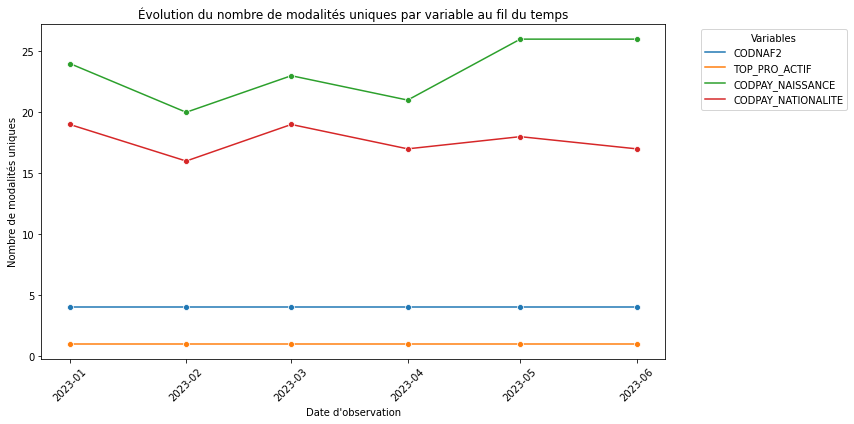

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Créer un DataFrame vide pour stocker les informations pour la visualisation
modalities_over_time = []

# Itérer sur les dates d'observation dans la colonne 'datdelhis'
for date in X_train['datdelhis'].unique():
    # Filtrer les données pour la date spécifique
    filtered_data = X_train[X_train['datdelhis'] == date]
    
    # Boucle sur chaque colonne catégorielle
    for col in object_columns:
        # Compter les modalités uniques pour cette date et colonne
        modalities = filtered_data[col].unique()  # Valeurs distinctes des modalités
        modalities_count = len(modalities)  # Compter le nombre de modalités uniques
        
        # Ajouter les résultats à la liste
        modalities_over_time.append({
            'date': date,
            'variable': col,
            'modalities_count': modalities_count
        })

# Convertir la liste en DataFrame pour faciliter la visualisation
modalities_df = pd.DataFrame(modalities_over_time)

# Affichage des modalités par date et variable
plt.figure(figsize=(12, 6))
sns.lineplot(data=modalities_df, x='date', y='modalities_count', hue='variable', marker='o')

# Améliorer l'apparence du graphique
plt.title("Évolution du nombre de modalités uniques par variable au fil du temps")
plt.xlabel("Date d'observation")
plt.ylabel("Nombre de modalités uniques")
plt.xticks(rotation=45)  # Rotation des dates pour une meilleure lisibilité
plt.legend(title="Variables", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Afficher le graphique
plt.show()


In [ ]:
# Itérer sur les dates d'observation dans la colonne 'datdelhis'
for date in X_train['datdelhis'].unique():
    print(f"Analyse pour la date d'observation : {date}")
    print()
    
    # Filtrer les données pour la date spécifique
    filtered_data = X_train[X_train['datdelhis'] == date]
    
    # Boucle sur chaque colonne catégorielle
    for col in ['CODPAY_NAISSANCE', 'CODPAY_NATIONALITE']:
        print(f"  Analyse de la disponibilité des modalités pour la variable : {col}")
        
        # Compter les modalités uniques et afficher les intitulés des modalités pour cette date
        modalities = filtered_data[col].unique()  # Valeurs distinctes des modalités
        modalities_count = len(modalities)  # Compter le nombre de modalités uniques
        
        # Afficher le nombre de modalités uniques et leurs intitulés
        print(f"    Nombre de modalités uniques pour {col} à {date} : {modalities_count}")
        print(f"    Intitulés des modalités : {modalities}")
    
    print("\n")


#### On s'assure de la cohérence et de la pertinence des variables de notre base

In [57]:
# Calcul des statistiques descriptives pour la colonne 'ANCIENNETE'
anciennete_stats = df['ANCIENNETE'].describe()

# Affichage des statistiques descriptives
print("Statistiques descriptives de la colonne 'ANCIENNETE' :")
print(anciennete_stats)

Statistiques descriptives de la colonne 'ANCIENNETE' :
count    495514.000000
mean        134.420575
std         119.480743
min           0.000000
25%          39.000000
50%         101.000000
75%         202.000000
max         881.000000
Name: ANCIENNETE, dtype: float64


In [26]:
### Cette variable doit probablement être exprimée en jours et non en mois comme stipulée dans l'énoncé

#### Creation de nouveaux indicateurs

In [ ]:
df['SECTNAF'] = df['CODNAF2'].str[-1]  ### On regroupe les seceurs d'activité en deux
#df["ANCENT"]= df['datdelhis'].dt.month - df['DATCREENT'].dt.month  ### On cree une nouvelle variable pour l'ancienneté de la SCI

## cet indicateur ne pourra pas être calculé anyway

In [61]:
#### On construit une nouvelle variable matérialisant l'ancienneté de la relation entre la SCI et la LCL
#### mais cette fois exprimée en mois

# Conversion de l'ancienneté (en jours) en mois (approximativement 30 jours par mois)
df['ANCIENNETE_MOIS'] = df['ANCIENNETE'] / 30
df['ANCIENNETE_MOIS'].describe()


count    495514.000000
mean          4.480686
std           3.982691
min           0.000000
25%           1.300000
50%           3.366667
75%           6.733333
max          29.366667
Name: ANCIENNETE_MOIS, dtype: float64

### 4- Selection des variables